In [1]:
!pip install pgmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.1 MB/s 


In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats
import scipy.optimize
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.linear_model import  LassoLarsIC
from sklearn.preprocessing import KBinsDiscretizer
from copy import  copy
from scipy.stats import t

from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import MaximumLikelihoodEstimator, BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.base import DAG
import networkx as nx
import statsmodels.api as sm
from sklearn.metrics import r2_score

from scipy.spatial.distance import jensenshannon

warnings.filterwarnings(action='ignore')
sns.set_theme(palette = "bright")


## Выберите переменные для семплирования из вашего набора данных (всего - около 10 переменных, 1-2 - целевые переменные, остальные - предикторы).

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/momo//

/content/drive/MyDrive/momo


In [5]:
df = pd.read_csv('Concrete_Data_Yeh.csv')

In [6]:
df.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cement            1030 non-null   float64
 1   slag              1030 non-null   float64
 2   flyash            1030 non-null   float64
 3   water             1030 non-null   float64
 4   superplasticizer  1030 non-null   float64
 5   coarseaggregate   1030 non-null   float64
 6   fineaggregate     1030 non-null   float64
 7   age               1030 non-null   int64  
 8   csMPa             1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


Cement (component 1) -- quantitative -- kg in a m3 mixture -- Input Variable

Blast Furnace Slag (component 2) -- quantitative -- kg in a m3 mixture -- Input Variable

Fly Ash (component 3) -- quantitative -- kg in a m3 mixture -- Input Variable

Water (component 4) -- quantitative -- kg in a m3 mixture -- Input Variable

Superplasticizer (component 5) -- quantitative -- kg in a m3 mixture -- Input Variable

Coarse Aggregate (component 6) -- quantitative -- kg in a m3 mixture -- Input Variable

Fine Aggregate (component 7) -- quantitative -- kg in a m3 mixture -- Input Variable

Age -- quantitative -- Day (1~365) -- Input Variable

Concrete compressive strength -- quantitative -- MPa -- Output Variable

In [ ]:
df.columns[:-1]

Index(['cement', 'slag', 'flyash', 'water', 'superplasticizer',
       'coarseaggregate', 'fineaggregate', 'age'],
      dtype='object')

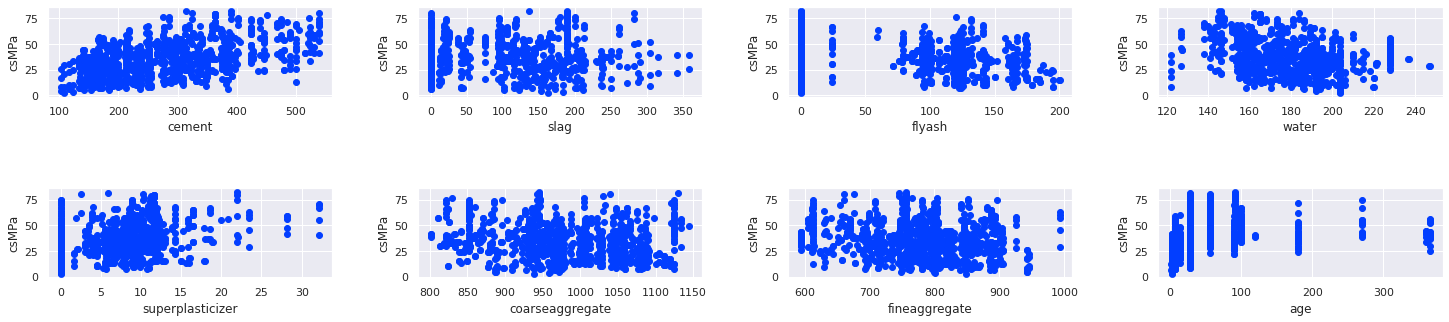

In [8]:
plt.figure(figsize=(25, 5))
plt.subplots_adjust(wspace=0.3, hspace=1)
plot_number = 0
for feature_name in df.columns[:-1]:
    plot_number += 1
    plt.subplot(2, 4, plot_number)
    plt.scatter(x=df[feature_name], y=df.csMPa)
    plt.ylabel('csMPa')
    plt.xlabel(feature_name)



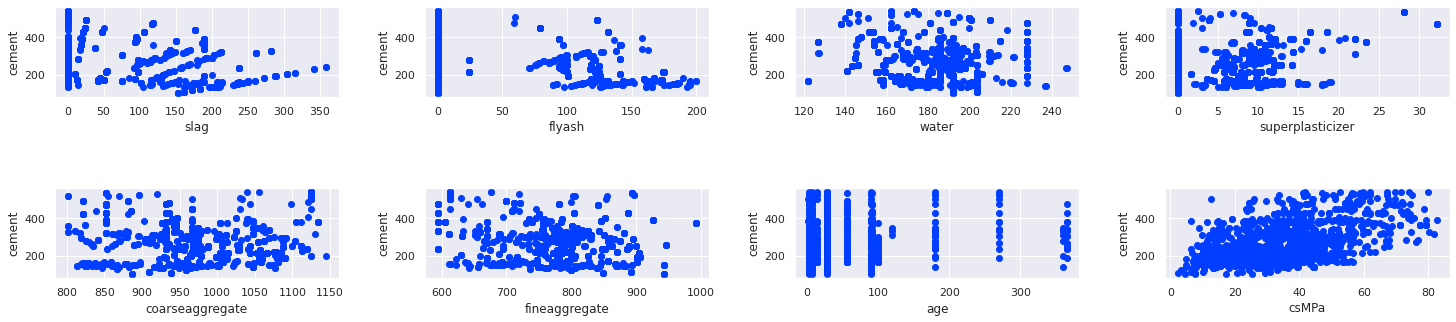

In [9]:
plt.figure(figsize=(25, 5))
plt.subplots_adjust(wspace=0.3, hspace=1)
plot_number = 0
for feature_name in df.columns[1:]:
    plot_number += 1
    plt.subplot(2, 4, plot_number)
    plt.scatter(x=df[feature_name], y=df.cement)
    plt.ylabel('cement')
    plt.xlabel(feature_name)

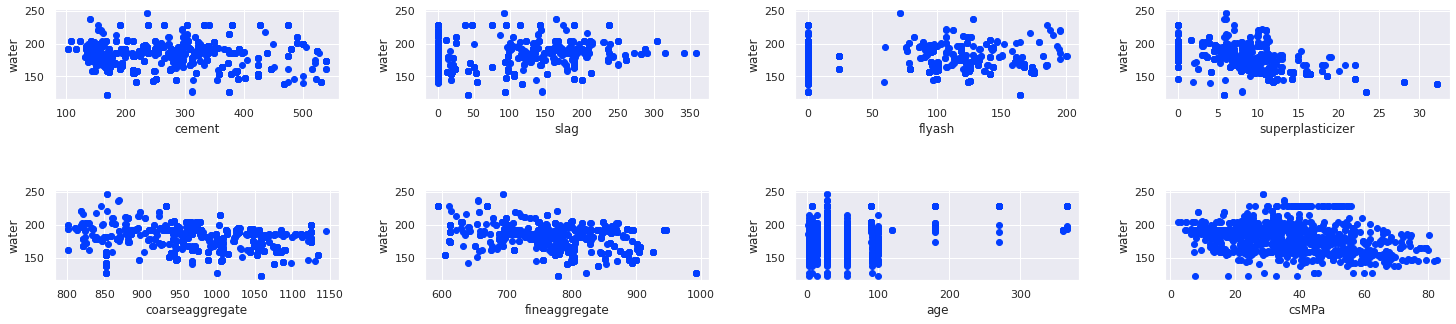

In [11]:
plt.figure(figsize=(25, 5))
plt.subplots_adjust(wspace=0.3, hspace=1)
plot_number = 0
for feature_name in df.drop(['water'],1).columns:
    plot_number += 1
    plt.subplot(2, 4, plot_number)
    plt.scatter(x=df[feature_name], y=df.water)
    plt.ylabel('water')
    plt.xlabel(feature_name)

## Выберите постановку задачи для регрессии. Оцените многомерную корреляцию (целевая переменная - предикторы)

Задача: минимизировать ошибку 

In [7]:
df.corr().csMPa

cement              0.497832
slag                0.134829
flyash             -0.105755
water              -0.289633
superplasticizer    0.366079
coarseaggregate    -0.164935
fineaggregate      -0.167241
age                 0.328873
csMPa               1.000000
Name: csMPa, dtype: float64

In [12]:
df.corr().cement

cement              1.000000
slag               -0.275216
flyash             -0.397467
water              -0.081587
superplasticizer    0.092386
coarseaggregate    -0.109349
fineaggregate      -0.222718
age                 0.081946
csMPa               0.497832
Name: cement, dtype: float64

In [13]:
df.corr().water

cement             -0.081587
slag                0.107252
flyash             -0.256984
water               1.000000
superplasticizer   -0.657533
coarseaggregate    -0.182294
fineaggregate      -0.450661
age                 0.277618
csMPa              -0.289633
Name: water, dtype: float64

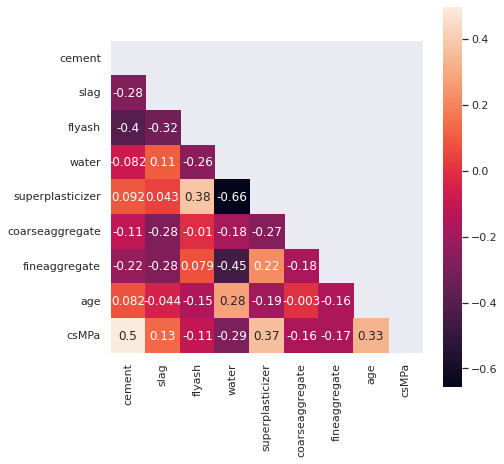

In [8]:
plt.figure(figsize=(7, 7))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(),annot = True,square=True,mask=matrix)

In [ ]:
df.columns

Index(['cement', 'slag', 'flyash', 'water', 'superplasticizer',
       'coarseaggregate', 'fineaggregate', 'age', 'csMPa'],
      dtype='object')

## Постройте регрессионную модель и проведите анализ мультиколлинеарности и регуляризации (при необходимости). 

In [ ]:
df.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


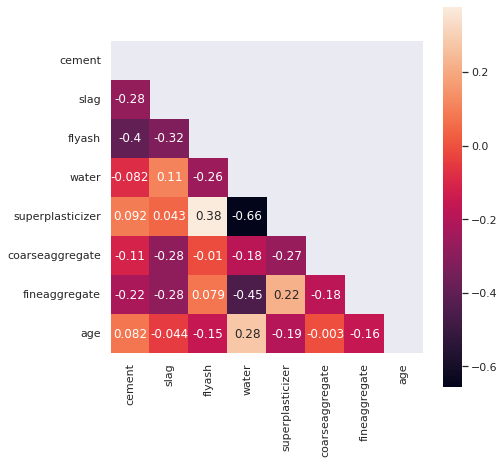

In [ ]:
plt.figure(figsize=(7, 7))
df_features = df.drop(['csMPa'],axis=1)
matrix = np.triu(df_features.corr())
sns.heatmap(df_features.corr(),annot = True,square=True,mask=matrix)

In [7]:
X = df.drop(['csMPa'],axis=1)
y = df[['csMPa']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
reg = LinearRegression(normalize=True)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
params = np.append(reg.intercept_,reg.coef_)

In [11]:
reg.coef_

array([[ 0.12268429,  0.11381623,  0.08943161, -0.09015135,  0.42843293,
         0.02793905,  0.03553352,  0.11546624]])

In [12]:
print("Train score: ", reg.score(X_train,y_train))
print("Test score: ", reg.score(X_test,y_test))

Train score:  0.6195712016559942
Test score:  0.5969851098437962


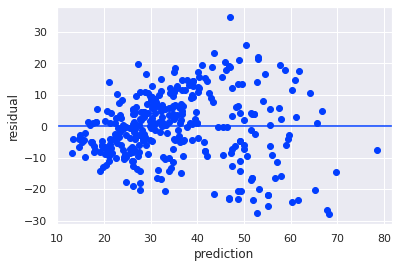

In [15]:
y_pred = reg.predict(X_test)
y_red = y_test - y_pred
plt.scatter(x=y_pred, y=y_red)

plt.ylabel("residual")
plt.xlabel("prediction")

plt.axhline(y=0)

In [14]:
X_train_cut = X_train.drop(['water'],1)
X_test_cut = X_test.drop(['water'],1)

In [15]:
reg2 = LinearRegression(normalize=True)
reg2.fit(X_train_cut, y_train)
print("Train score: ", reg2.score(X_train_cut,y_train))
print("Test score: ", reg2.score(X_test_cut,y_test))

Train score:  0.6175720230424788
Test score:  0.5878575675749578


In [16]:
reg2.coef_

array([[0.13617524, 0.12936479, 0.10741736, 0.53765832, 0.04490208,
        0.05479774, 0.11467837]])

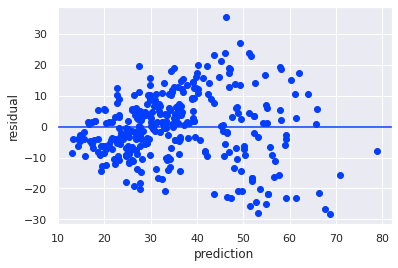

In [19]:
y_pred = reg2.predict(X_test_cut)
y_red = y_test - y_pred
plt.scatter(x=y_pred, y=y_red)
plt.ylabel("residual")
plt.xlabel("prediction")
plt.axhline(y=0)

In [18]:
X_train_cut2 = X_train.drop(['superplasticizer', 'fineaggregate'],1)
X_test_cut2 = X_test.drop(['superplasticizer', 'fineaggregate'],1)

In [19]:
reg2 = LinearRegression(normalize=True)
reg2.fit(X_train_cut2, y_train)
print("Train score: ", reg2.score(X_train_cut2,y_train))
print("Test score: ", reg2.score(X_test_cut2,y_test))

Train score:  0.6083919508770359
Test score:  0.610005270689151


In [20]:
reg2.coef_

array([[ 0.10293849,  0.09001279,  0.06861171, -0.26437817, -0.00635899,
         0.11518686]])

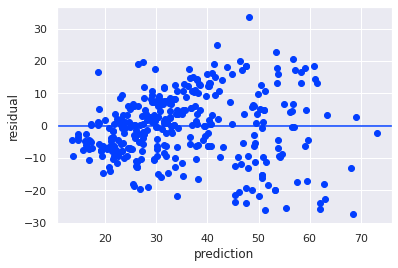

In [96]:
y_pred = reg2.predict(X_test_cut2)
y_red = y_test - y_pred
plt.scatter(x=y_pred, y=y_red)
plt.ylabel("residual")
plt.xlabel("prediction")
plt.axhline(y=0)

Quantile:  1.6494423443625221
Sigma:  [10.54426992]


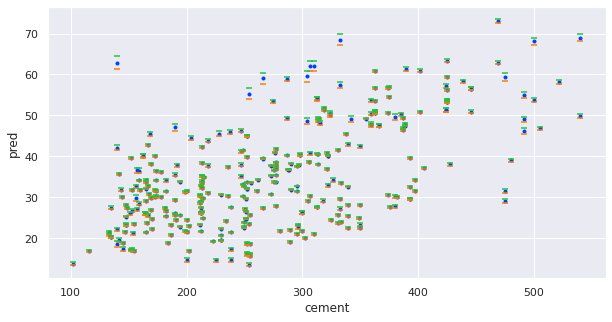

In [97]:
n_params = reg2.coef_.shape[1] +1
intervals = predict_interval(X_test_cut2, n_params, np.array(y_test), y_pred)
plt.figure(figsize=(10, 5)) 

plt.xlabel(X_test_cut2.iloc[:,0].name)
plt.ylabel("pred")
plt.scatter(X_test_cut2.iloc[:,0], y_pred, marker=".")
plt.scatter(X_test_cut2.iloc[:,0], intervals.lower,marker="_")
plt.scatter(X_test_cut2.iloc[:,0], intervals.upper,marker="_")

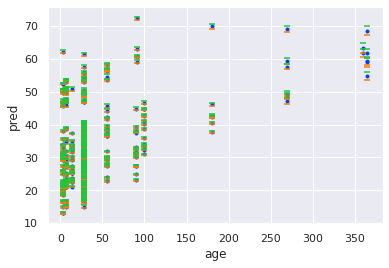

In [68]:
plt.xlabel(X_test_cut2.iloc[:,-1].name)
plt.ylabel("pred")
plt.scatter(X_test_cut2.iloc[:,-1], y_pred, marker=".")
plt.scatter(X_test_cut2.iloc[:,-1], intervals.lower,marker="_")
plt.scatter(X_test_cut2.iloc[:,-1], intervals.upper,marker="_")

In [69]:
lasso = linear_model.Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
print(lasso.coef_)

[ 0.12267053  0.11379782  0.08942113 -0.09031735  0.42779393  0.02790338
  0.03550714  0.11546181]


In [70]:
print("Train score: ", lasso.score(X_train,y_train))
print("Test score: ", lasso.score(X_test,y_test))

Train score:  0.6195711806726958
Test score:  0.5970090634137433


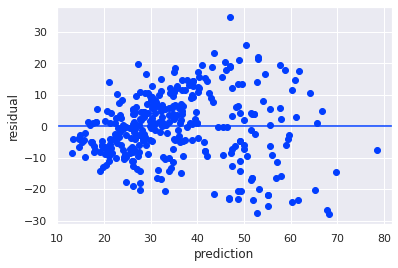

In [72]:
y_pred = lasso.predict(X_test)
y_true = np.array(y_test).ravel()
y_red = y_true - y_pred
plt.scatter(x=y_pred, y=y_red)
plt.ylabel("residual")
plt.xlabel("prediction")
plt.axhline(y=0)

In [27]:
lasso = linear_model.Lasso(alpha=0.01)
lasso.fit(X_train_cut, y_train)
print(lasso.coef_)

[0.13618632 0.12937501 0.10743999 0.53722047 0.04489764 0.05480682
 0.11467248]


Train score:  0.6175720088391989
Test score:  0.5878676026180731


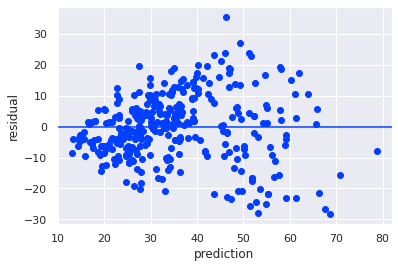

In [29]:
print("Train score: ", lasso.score(X_train_cut,y_train))
print("Test score: ", lasso.score(X_test_cut,y_test))

y_pred = lasso.predict(X_test_cut)
y_true = np.array(y_test).ravel()
y_red = y_true - y_pred
plt.scatter(x=y_pred, y=y_red)
plt.ylabel("residual")
plt.xlabel("prediction")
plt.axhline(y=0)

In [35]:
lasso = linear_model.Lasso(alpha=0.01)
lasso.fit(X_train_cut2, y_train)
print(lasso.coef_)

[ 0.10293684  0.09000956  0.06860813 -0.26435284 -0.00635762  0.11518144]


In [31]:
lasso.coef_.shape[0]

6

Train score:  0.6083919494145518
Test score:  0.61000408230741


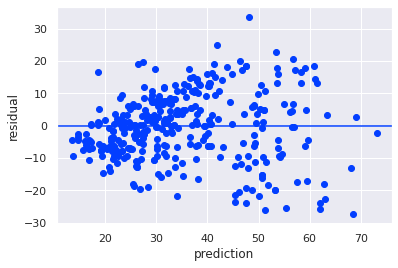

In [32]:
print("Train score: ", lasso.score(X_train_cut2,y_train))
print("Test score: ", lasso.score(X_test_cut2,y_test))
y_pred = lasso.predict(X_test_cut2)
y_true = np.array(y_test).ravel()
y_red = y_true - y_pred
plt.scatter(x=y_pred, y=y_red)
plt.ylabel("residual")
plt.xlabel("prediction")
plt.axhline(y=0)

In [41]:
parameters = {'alpha': np.linspace(0, 10, 100)}
# parameters_alpha = {'alpha': [0.1,0.01,0.001,1,5,10]}

grid_search = GridSearchCV(lasso, parameters_alpha, cv=2, n_jobs=1)
grid_search.fit(X_train_cut2, y_train)

GridSearchCV(cv=2, estimator=Lasso(alpha=0.01), n_jobs=1,
             param_grid={'alpha': [0.1, 0.01, 0.001, 1, 5, 10]})

In [42]:
grid_search.best_params_

{'alpha': 5}

In [43]:
grid_search.best_estimator_.score(X_test_cut2,y_test)

0.6090692328771765

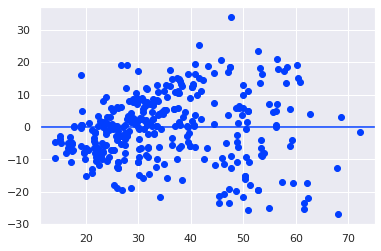

In [40]:
y_pred = grid_search.best_estimator_.predict(X_test_cut2)
y_true = np.array(y_test).ravel()
y_red = y_true - y_pred
plt.scatter(x=y_pred, y=y_red)
plt.axhline(y=0)

In [43]:
X_train_cut3 = X_train_cut2.drop(['coarseaggregate'],1)
X_test_cut3 = X_test_cut2.drop(['coarseaggregate'],1)

[ 0.10481857  0.0929804   0.0717465  -0.25826309  0.11505286]
Train score:  0.6076976055931471
Test score:  0.6115789866716437


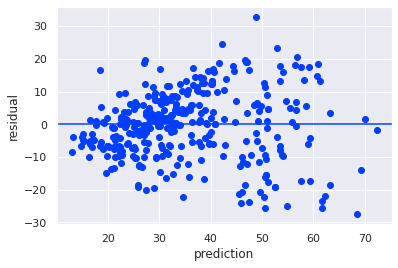

In [45]:
lasso = linear_model.Lasso(alpha=0.1)
lasso.fit(X_train_cut3, y_train)
print(lasso.coef_)
print("Train score: ", lasso.score(X_train_cut3,y_train))
print("Test score: ", lasso.score(X_test_cut3,y_test))
y_pred = lasso.predict(X_test_cut3)
y_true = np.array(y_test).ravel()
y_red = y_true - y_pred
plt.scatter(x=y_pred, y=y_red)
plt.ylabel("residual")
plt.xlabel("prediction")
plt.axhline(y=0)

Train score:  0.9315863392514895
Test score:  0.8594197964546111


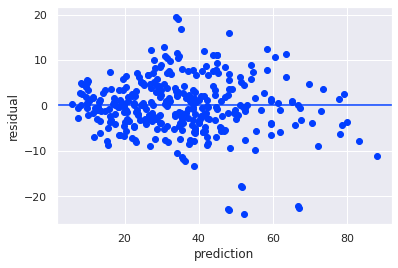

In [62]:
from sklearn.preprocessing import PolynomialFeatures

poly_reg = PolynomialFeatures(degree=3)

X_poly = poly_reg.fit_transform(X_train)
X_poly_test = poly_reg.transform(X_test)

pol_reg = LinearRegression()
pol_reg.fit(X_poly, y_train)

print("Train score: ", pol_reg.score(X_poly,y_train))
print("Test score: ", pol_reg.score(X_poly_test,y_test))

y_pred = pol_reg.predict(X_poly_test)
y_red = y_test - y_pred
plt.scatter(x=y_pred, y=y_red)

plt.ylabel("residual")
plt.xlabel("prediction")

plt.axhline(y=0)

Train score:  0.9125130136057491
Test score:  0.8450137820187242


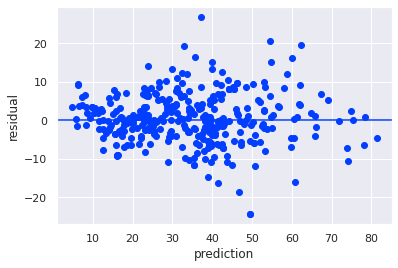

In [50]:
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train_cut)
X_poly_test = poly_reg.transform(X_test_cut)

pol_reg = LinearRegression()
pol_reg.fit(X_poly, y_train)

print("Train score: ", pol_reg.score(X_poly,y_train))
print("Test score: ", pol_reg.score(X_poly_test,y_test))

y_pred = pol_reg.predict(X_poly_test)
y_red = y_test - y_pred
plt.scatter(x=y_pred, y=y_red)

plt.ylabel("residual")
plt.xlabel("prediction")

plt.axhline(y=0)

Train score:  0.8883904241187247
Test score:  0.832717663429258


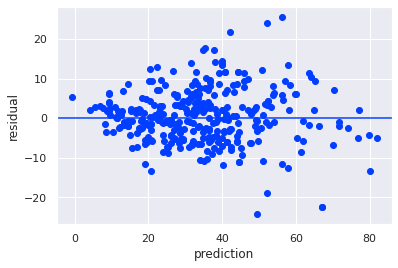

In [53]:
poly_reg = PolynomialFeatures(degree=3)
X_poly = poly_reg.fit_transform(X_train_cut2)
X_poly_test = poly_reg.transform(X_test_cut2)

pol_reg = LinearRegression()
pol_reg.fit(X_poly, y_train)

print("Train score: ", pol_reg.score(X_poly,y_train))
print("Test score: ", pol_reg.score(X_poly_test,y_test))

y_pred = pol_reg.predict(X_poly_test)
y_red = y_test - y_pred
plt.scatter(x=y_pred, y=y_red)

plt.ylabel("residual")
plt.xlabel("prediction")

plt.axhline(y=0)

In [59]:
pol_reg.coef_.shape[1]

165

In [80]:
pd.DataFrame(X_poly_test).iloc[:,8]

0      365.0
1        7.0
2       28.0
3        3.0
4       28.0
       ...  
335     28.0
336      3.0
337     90.0
338     28.0
339     28.0
Name: 8, Length: 340, dtype: float64

In [76]:
n_params = pol_reg.coef_.shape[1] +1
intervals = predict_interval(pd.DataFrame(X_poly_test), n_params, np.array(y_test), y_pred,model='l')
plt.figure(figsize=(10, 5)) 

Quantile:  1.653658016514993
Sigma:  [8.75783427]


<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

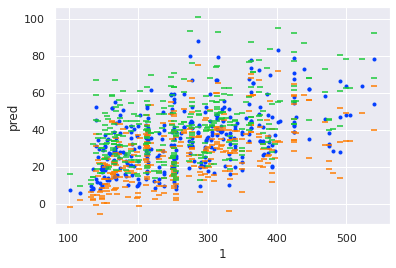

In [78]:
plt.xlabel(pd.DataFrame(X_poly_test).iloc[:,1].name)
plt.ylabel("pred")
plt.scatter(pd.DataFrame(X_poly_test).iloc[:,1], y_pred, marker=".")
plt.scatter(pd.DataFrame(X_poly_test).iloc[:,1], intervals.lower,marker="_")
plt.scatter(pd.DataFrame(X_poly_test).iloc[:,1], intervals.upper,marker="_")

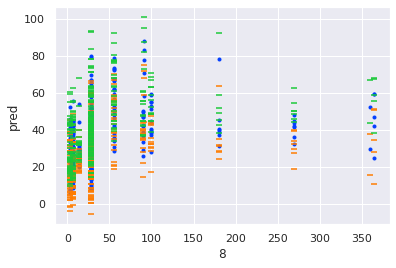

In [81]:
plt.xlabel(pd.DataFrame(X_poly_test).iloc[:,8].name)
plt.ylabel("pred")
plt.scatter(pd.DataFrame(X_poly_test).iloc[:,8], y_pred, marker=".")
plt.scatter(pd.DataFrame(X_poly_test).iloc[:,8], intervals.lower,marker="_")
plt.scatter(pd.DataFrame(X_poly_test).iloc[:,8], intervals.upper,marker="_")

# **Intervsls**

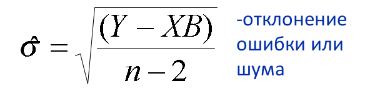

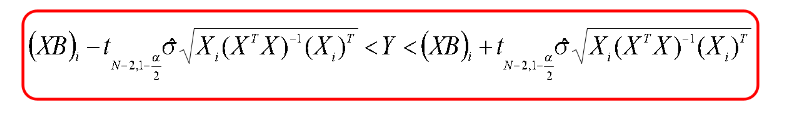

In [64]:
def predict_interval(X,var_n, y_test, y_pred, alpha=0.1, model = 'linear'):
    # var_n - количество параметров модели
    N = len(X)
    # Quantile of Student's t distribution for p=(1-alpha/2)
    
    q = t.ppf(1.0 - alpha / 2.0, N - var_n)
    print("Quantile: ", q)
    sigma =0
    if model == 'linear':
        sigma = np.sqrt(sum((y_test.values - y_pred)**2)/(N - var_n))  
    else:

        sigma = np.sqrt(sum((y_test - y_pred)**2)/(N - var_n))
    print("Sigma: ", sigma)

    ddd = pd.DataFrame(y_pred,columns=['prediction'])
    iter = 0

    for xb in y_pred:

        x = X.iloc[iter,:].values
        inv_1 = np.matmul(X.transpose(), X)
        inv_1 = np.linalg.inv(inv_1)
        inv_2 = x.transpose()
        root = np.matmul(x,inv_1)
        root = np.matmul(root,inv_2)
        ddd.loc[iter, 'lower'] = xb - q * sigma * root
        ddd.loc[iter, 'upper'] = xb + q * sigma * root
        iter+=1
    
    return ddd


Quantile:  1.6494423443625221
Sigma:  [10.54426992]


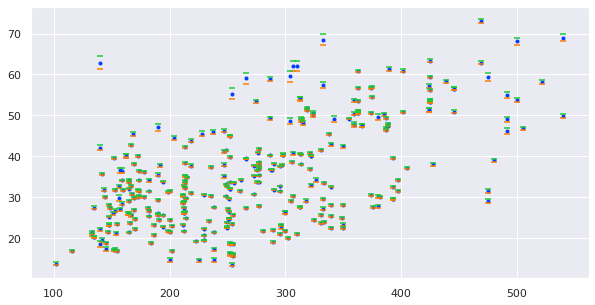

In [98]:
intervals = predict_interval(X_test_cut2, 7, np.array(y_test), y_pred)
plt.figure(figsize=(10, 5)) 

plt.scatter(X_test_cut2.iloc[:,0], y_pred, marker=".")
plt.scatter(X_test_cut2.iloc[:,0], intervals.lower,marker="_")
plt.scatter(X_test_cut2.iloc[:,0], intervals.upper,marker="_")

Quantile:  1.6494423443625221
Sigma:  10.544285985644114


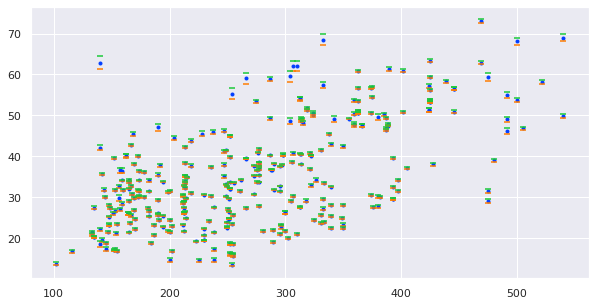

In [116]:
n_params = lasso.coef_.shape[0] +1

y_pred = np.array(lasso.predict(X_test_cut2))
y_true = np.array(y_test).ravel()

intervals = predict_interval(X_test_cut2, n_params, y_true, y_pred,model='l')

plt.figure(figsize=(10, 5)) 
plt.ylabel("Prediction")
plt.xlabel(X_test_cut2.iloc[:,0].name)
plt.scatter(X_test_cut2.iloc[:,0], y_pred, marker=".")
plt.scatter(X_test_cut2.iloc[:,0], intervals.lower,marker="_")
plt.scatter(X_test_cut2.iloc[:,0], intervals.upper,marker="_")


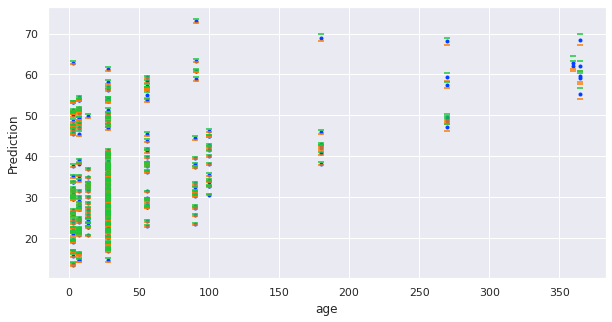

In [117]:
plt.figure(figsize=(10, 5)) 
plt.ylabel("Prediction")
plt.xlabel(X_test_cut2.iloc[:,-1].name)
plt.scatter(X_test_cut2.iloc[:,-1], y_pred, marker=".")
plt.scatter(X_test_cut2.iloc[:,-1], intervals.lower,marker="_")
plt.scatter(X_test_cut2.iloc[:,-1], intervals.upper,marker="_")

## Проанализируйте качество регрессионной модели (распределение остатков, коэффициент детерминации). Постройте вероятностный интервал для результатов регрессии.

In [ ]:
def residuals(y_true,y_pred):
    data= pd.DataFrame(data=y_pred,columns=['predicted'])
    data["residuals"] = y_pred -  y_true 
    sns.scatterplot(data=data,x="predicted", y="residuals")
    plt.axhline(y=0)

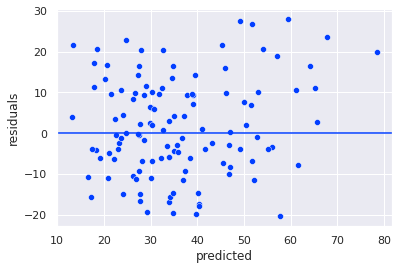

In [ ]:
residuals(y_test,y_pred)

Добавить распределение остатков

In [ ]:
print("Train score: ", model_aic.score(X_train,y_train))
print("Test score: ", model_aic.score(X_test,y_test))

Train score:  0.6195712016559942
Test score:  0.5969851098437966


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cement            1030 non-null   float64
 1   slag              1030 non-null   float64
 2   flyash            1030 non-null   float64
 3   water             1030 non-null   float64
 4   superplasticizer  1030 non-null   float64
 5   coarseaggregate   1030 non-null   float64
 6   fineaggregate     1030 non-null   float64
 7   age               1030 non-null   int64  
 8   csMPa             1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


##  Постройте байесовскую сеть для выбранного набора переменных. Определите ее структуру на основе многомерного анализа или обучите структуру с помощью 2 выбранных алгоритмов.

In [84]:
df.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [85]:
df.columns

Index(['cement', 'slag', 'flyash', 'water', 'superplasticizer',
       'coarseaggregate', 'fineaggregate', 'age', 'csMPa'],
      dtype='object')

In [168]:
transformed_data = copy(df)

est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
data_discrete = est.fit_transform(transformed_data.drop('age',1).values)
transformed_data[['cement', 'slag', 'flyash', 'water', 'superplasticizer','coarseaggregate', 'fineaggregate', 'csMPa']] = data_discrete

In [87]:
transformed_data.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,9.0,0.0,0.0,3.0,0.0,7.0,1.0,28,9.0
1,9.0,0.0,0.0,3.0,0.0,7.0,1.0,28,7.0
2,5.0,3.0,0.0,8.0,0.0,3.0,0.0,270,4.0
3,5.0,3.0,0.0,8.0,0.0,3.0,0.0,365,4.0
4,2.0,3.0,0.0,5.0,0.0,4.0,5.0,360,5.0


In [152]:
poly_featch = PolynomialFeatures(degree=3)
df_poly = poly_featch.fit_transform(df)

In [161]:
transformed_data_poly = copy(pd.DataFrame(df_poly))
est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')

data_discrete = est.fit_transform(transformed_data_poly)
transformed_data_poly = data_discrete

In [125]:
hc = HillClimbSearch(transformed_data, {"scoring_method": BicScore(transformed_data)})

In [126]:
best_model = hc.estimate()

  0%|          | 0/1000000 [00:00<?, ?it/s]

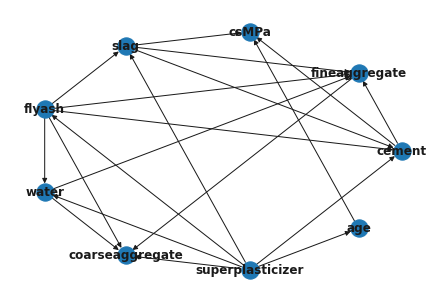

In [127]:
G_BIC = nx.DiGraph()
G_BIC.add_edges_from(best_model.edges())
pos = nx.layout.circular_layout(G_BIC)
nx.draw(G_BIC, pos, with_labels=True,font_weight='bold')

In [97]:
bdeu = BDeuScore(transformed_data, equivalent_sample_size=5)
k2 = K2Score(transformed_data)
bic = BicScore(transformed_data)

In [98]:
print(f'BDeu: {bdeu.score(best_model)}')
print(f'K2: {k2.score(best_model)}')
print(f'BIC: {bic.score(best_model)}')


BDeu: -15080.62449334702
K2: -14973.966271601465
BIC: -715446.1888720635


In [99]:
ks2 = HillClimbSearch(transformed_data, {"scoring_method": K2Score(transformed_data)})
best_model_ks2 = ks2.estimate()

  0%|          | 0/1000000 [00:00<?, ?it/s]

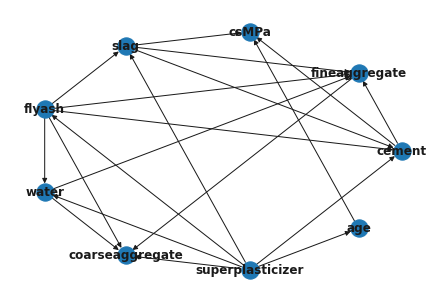

In [100]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(best_model_ks2.edges())
pos = nx.layout.circular_layout(G_K2)
nx.draw(G_K2, pos, with_labels=True,font_weight='bold')

In [101]:
print(f'BDeu: {bdeu.score(best_model_ks2)}')
print(f'K2: {k2.score(best_model_ks2)}')
print(f'BIC: {bic.score(best_model_ks2)}')

BDeu: -15080.62449334702
K2: -14973.966271601465
BIC: -715446.1888720635


In [123]:
blacklist = [(x, y) for x in transformed_data.columns.to_list() for y in ['coarseaggregate','fineaggregate','superplasticizer'] if x != y]
blacklist

[('cement', 'coarseaggregate'),
 ('cement', 'fineaggregate'),
 ('cement', 'superplasticizer'),
 ('slag', 'coarseaggregate'),
 ('slag', 'fineaggregate'),
 ('slag', 'superplasticizer'),
 ('flyash', 'coarseaggregate'),
 ('flyash', 'fineaggregate'),
 ('flyash', 'superplasticizer'),
 ('water', 'coarseaggregate'),
 ('water', 'fineaggregate'),
 ('water', 'superplasticizer'),
 ('superplasticizer', 'coarseaggregate'),
 ('superplasticizer', 'fineaggregate'),
 ('coarseaggregate', 'fineaggregate'),
 ('coarseaggregate', 'superplasticizer'),
 ('fineaggregate', 'coarseaggregate'),
 ('fineaggregate', 'superplasticizer'),
 ('age', 'coarseaggregate'),
 ('age', 'fineaggregate'),
 ('age', 'superplasticizer'),
 ('csMPa', 'coarseaggregate'),
 ('csMPa', 'fineaggregate'),
 ('csMPa', 'superplasticizer')]

In [113]:
transformed_data.head()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,9.0,0.0,0.0,3.0,0.0,7.0,1.0,28,9.0
1,9.0,0.0,0.0,3.0,0.0,7.0,1.0,28,7.0
2,5.0,3.0,0.0,8.0,0.0,3.0,0.0,270,4.0
3,5.0,3.0,0.0,8.0,0.0,3.0,0.0,365,4.0
4,2.0,3.0,0.0,5.0,0.0,4.0,5.0,360,5.0


  0%|          | 0/1000000 [00:00<?, ?it/s]

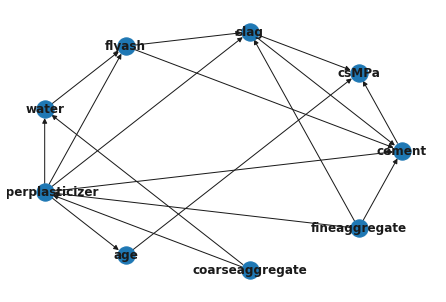

In [120]:
bdu = HillClimbSearch(transformed_data, {"scoring_method": BDeuScore(transformed_data)})
best_model_bdu = bdu.estimate(black_list=blacklist)
G_K2 = nx.DiGraph()
G_K2.add_edges_from(best_model_bdu.edges())
pos = nx.layout.circular_layout(G_K2)
nx.draw(G_K2, pos, with_labels=True,font_weight='bold')

In [121]:
print(f'BDeu: {bdeu.score(best_model_bdu)}')
print(f'K2: {k2.score(best_model_bdu)}')
print(f'BIC: {bic.score(best_model_bdu)}')

BDeu: -16126.007038468751
K2: -15833.549619856927
BIC: -407436.0659306928


  0%|          | 0/1000000 [00:00<?, ?it/s]

BDeu: -16336.658222815531
K2: -15976.222182807942
BIC: -405163.397557473


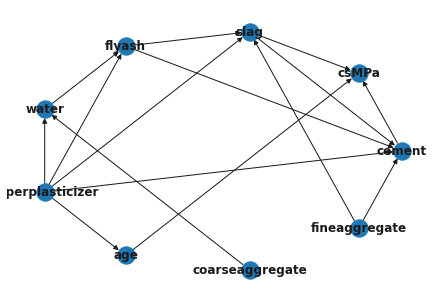

In [124]:
bic2 = HillClimbSearch(transformed_data, {"scoring_method": BicScore(transformed_data)})
best_model_bic2 = bic2.estimate(black_list=blacklist)
G_K2 = nx.DiGraph()
G_K2.add_edges_from(best_model_bic2.edges())
pos = nx.layout.circular_layout(G_K2)
nx.draw(G_K2, pos, with_labels=True,font_weight='bold')

print(f'BDeu: {bdeu.score(best_model_bic2)}')
print(f'K2: {k2.score(best_model_bic2)}')
print(f'BIC: {bic.score(best_model_bic2)}')

##  Выполните задачу регрессии с помощью БС. Постройте вероятностный интервал для результатов регрессии на основе семплирования из БС. Оцените качество предсказания БС. 

In [128]:
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling

bn_new = BayesianModel(best_model.edges())
bn_new.fit(transformed_data)

In [129]:
bn_new.check_model()

True

In [136]:
best_model.edges()

OutEdgeView([('cement', 'water'), ('cement', 'csMPa'), ('slag', 'cement'), ('slag', 'water'), ('slag', 'csMPa'), ('flyash', 'cement'), ('flyash', 'slag'), ('flyash', 'water'), ('flyash', 'age'), ('age', 'csMPa')])

In [169]:
train_data = transformed_data[:800]
predict_data = transformed_data[800:]

model = BayesianModel(best_model_bic2.edges())
model.fit(transformed_data)

predict_data2 = predict_data.copy()
predict_data2.drop('csMPa', axis=1, inplace=True)

y_pred = model.predict(predict_data2)
r2_score(predict_data.csMPa,y_pred)



  0%|          | 0/138 [00:00<?, ?it/s]

0.6782800522540731

In [130]:
train_data = transformed_data[:800]
predict_data = transformed_data[800:]

model = BayesianModel(best_model.edges())
model.fit(transformed_data)

predict_data2 = predict_data.copy()
predict_data2.drop('csMPa', axis=1, inplace=True)
print(predict_data2)
y_pred = model.predict(predict_data2)
y_pred


      cement  slag  flyash  water  superplasticizer  coarseaggregate  \
800      3.0   0.0     0.0    5.0               0.0              9.0   
801      3.0   0.0     0.0    5.0               0.0              9.0   
802      5.0   0.0     0.0    5.0               0.0              7.0   
803      6.0   0.0     0.0    5.0               0.0              3.0   
804      6.0   0.0     0.0    5.0               0.0              3.0   
...      ...   ...     ...    ...               ...              ...   
1025     3.0   3.0     4.0    4.0               2.0              1.0   
1026     4.0   0.0     5.0    6.0               3.0              0.0   
1027     0.0   3.0     5.0    5.0               1.0              2.0   
1028     1.0   5.0     0.0    4.0               3.0              5.0   
1029     3.0   2.0     3.0    6.0               2.0              1.0   

      fineaggregate  age  
800             4.0    7  
801             4.0   28  
802             3.0   28  
803             3.0    3  


  0%|          | 0/138 [00:00<?, ?it/s]

,csMPa
0,0.0
1,3.0
2,3.0
3,1.0
4,4.0
...,...
225,5.0
226,2.0
227,2.0
228,3.0


In [131]:
r2_score(predict_data.csMPa,y_pred)


0.6782800522540731

ДОБАВИТЬ НАЗВАНИЯ ОСЕЙ

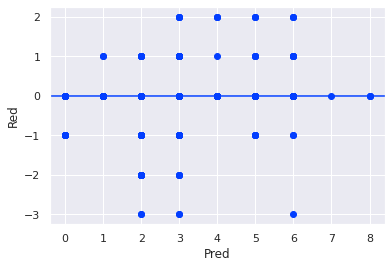

In [133]:
y_pred =  np.array(y_pred).ravel()
y_true = predict_data.csMPa.values
y_red = y_pred-y_true
plt.scatter(x=y_pred, y=y_red)
plt.ylabel("Red")
plt.xlabel("Pred")
plt.axhline(y=0)

In [138]:
n_params = 2

intervals = predict_interval(predict_data2, n_params, y_true, y_pred,model='l')

Quantile:  1.6515642280669298
Sigma:  0.9978046076701186


Text(0.5, 0, 'cement')

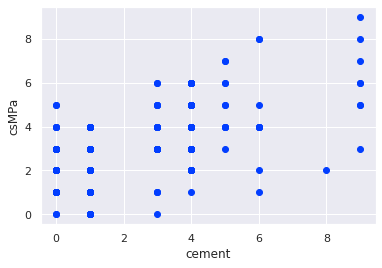

In [144]:
plt.scatter(predict_data.cement,predict_data.csMPa)
plt.ylabel('csMPa')
plt.xlabel('cement')

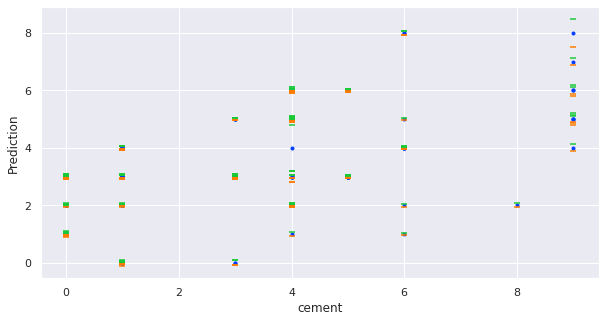

In [139]:

plt.figure(figsize=(10, 5)) 
plt.ylabel("Prediction")
plt.xlabel(predict_data.iloc[:,0].name)
plt.scatter(predict_data.iloc[:,0], y_pred, marker=".")
plt.scatter(predict_data.iloc[:,0], intervals.lower,marker="_")
plt.scatter(predict_data.iloc[:,0], intervals.upper,marker="_")


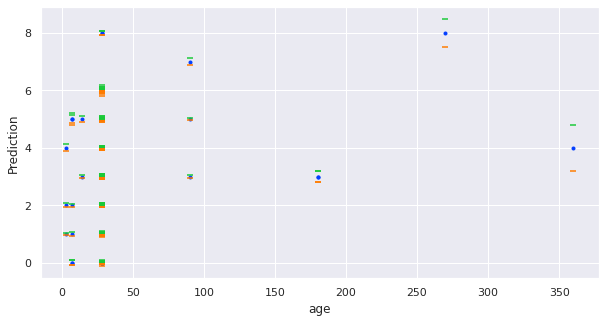

In [140]:
plt.figure(figsize=(10, 5)) 
plt.ylabel("Prediction")
plt.xlabel(predict_data.iloc[:,-2].name)
plt.scatter(predict_data.iloc[:,-2], y_pred, marker=".")
plt.scatter(predict_data.iloc[:,-2], intervals.lower,marker="_")
plt.scatter(predict_data.iloc[:,-2], intervals.upper,marker="_")

Text(0.5, 0, 'age')

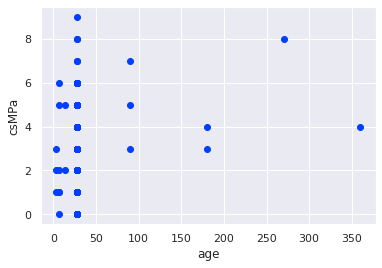

In [142]:
plt.scatter(predict_data.age,predict_data.csMPa)
plt.ylabel('csMPa')
plt.xlabel('age')